In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import sys
sys.path.append('/kaggle/usr/lib')

from basic_preprocessing_utility_script import process_as_h5, signature, get_eeg_sp_data

import numpy as np
import pandas as pd
import os
import time
import h5py
from tqdm import tqdm

import iisignature as isig

import matplotlib.pyplot as plt

iisignature not found. Installing...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.6 MB/s eta 0:00:0000:010:01
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for iisignature: filename=iisignature-0.24-cp310-cp310-linux_x86_64.whl size=1401821 sha256=757a15b85d0e66a7735d44d0acf037678a051e0d6064896dca3a626e87ba8657
  Stored in directory: /root/.cache/pip/wheels/c8/13/d1/42e1aa7f8a8e1189360df53c461f0e13f43e0d2170ef16d349
Successfully built iisignature


In [ ]:
# filename = '/kaggle/input/hms-harmful-brain-activity-classification/train.csv'
# process_as_h5(filename, num_examples = 1000)


In [2]:
hdf5_file = '/kaggle/input/hms-data-first-third/hdf5/processed_dataset_0_17799.h5'


with h5py.File(hdf5_file, 'r') as file:
    # List all groups
    
    print("Keys: %s" % file.keys())
    
    file_keys = list(file.keys())

    a_group_key = list(file.keys())[0]
    
    eeg_data = np.array(file[f"eeg"])
    sp_data = np.array(file[f"sp"])
    targets = np.array(file[f"targets"])
    num_votes = np.array(file[f"num_votes"])
    num_votes = num_votes.reshape((len(num_votes), -1))
    

Keys: <KeysViewHDF5 ['eeg', 'num_votes', 'sp', 'targets']>


In [63]:
def signature_w_concat(data, level=2, chunk_len=None, concatenate=True): # with log sig
    """Performs signature on data needs data to be 3d,
    
    if input to isig.sig is (num_examples, num_time_steps, dim_of_data_at_each_time_step)
    then the output will be (num_examples, isig.sig_length(dim_of_data_at_each_time_step, level))
    
    chunk_len will split the timesteps (i.e. the second dimension) into chunks of length chunk_len
    
    
    """
    assert len(data.shape) == 3, f"data needs to be 3d. data is {data.shape} If it is 2d, reshape so first dim is 1"
    
#     if chunk_len is not None:
#         assert chunk_len < data.shape[2], f"chunk length is bigger than the number of time steps"
    
#     if chunk_len is None:
#         sig_len = isig.siglength(data.shape[2], level)
#         assert sig_len > 0 , "Too many elements in each chunk. Signature package thinks the num of elements is negative lol"
    
#     if chunk_len is not None:
#         sig_len = isig.siglength(data.shape[2], level)
#         assert sig_len > 0 , "Too many elements in each chunk. Signature package thinks the num of elements is negative lol"
    
    if chunk_len is None:
        s = isig.prepare (data.shape[-1], level)
        logsignature = isig.logsig (data, s)
        return np.array(logsignature) # np.array(sig_arr)
        
    else:
        num_whole_chunks = (data.shape[1] // chunk_len)
        remainder = data.shape[1] % chunk_len

        sig_arr = []

        for j in range(1,num_whole_chunks):
            sub_dat = data[:, j*chunk_len: (j+1)*chunk_len, :]
            sig_output = isig.sig(sub_dat, level)
            sig_arr.append(sig_output.reshape(sig_output.shape[0], 1, sig_output.shape[1]))

        # Handling the remainder if it exists
        if remainder != 0:
            sub_dat = data[:, num_whole_chunks*chunk_len:, ]
            sig_output = isig.sig(sub_dat, level)
            sig_arr.append(sig_output.reshape(sig_output.shape[0], 1, sig_output.shape[1]))

        if concatenate:
            return np.concatenate(sig_arr, axis=1)
        else:
            return sig_arr

In [54]:
# from sklearn.manifold import MDS
# from sklearn.datasets import load_digits

# from sklearn.preprocessing import StandardScaler

# # Initialize the StandardScaler
# scaler = StandardScaler()

In [70]:
def signature_op(arr):
    if len(arr.shape) == 2:
        arr = arr[None,:,:]
        
    sig_arr = signature_w_concat(arr, level=2, chunk_len = None, concatenate=True)
    sig_arr = np.reshape(sig_arr, (1,401,-1))
    return sig_arr

In [71]:
aa = signature_op(sp_data[0])

In [72]:
aa.shape

(1, 401, 200)

In [ ]:
sp_data = sp_data.reshape((-1,300,400))

sp_data.shape

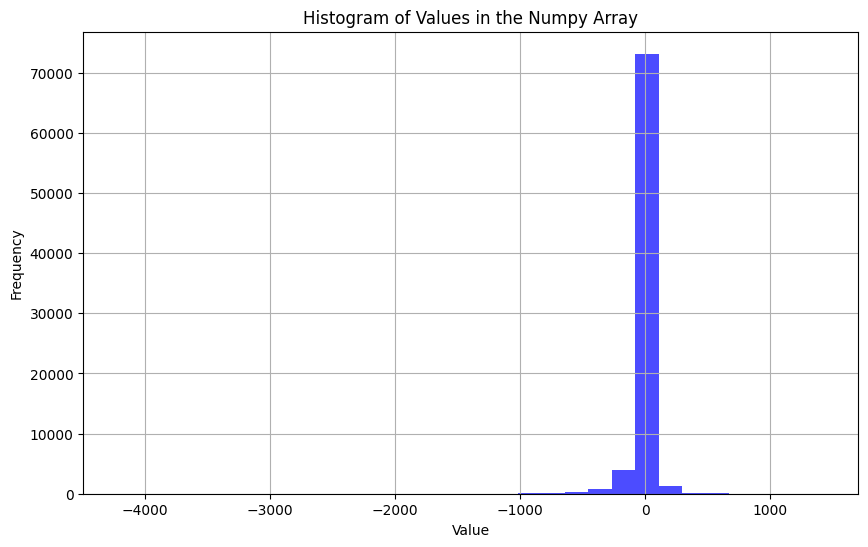

In [58]:
plt.figure(figsize=(10, 6))
plt.hist(aa.flatten(), bins=30, alpha=0.7, color='blue')
plt.title('Histogram of Values in the Numpy Array')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [59]:
print(np.max(aa))

1421.0142610360358


In [75]:
import numpy as np

def percentage_in_range(vector, range_min, range_max):
    """
    Prints the percentage of points within a specified range in a NumPy vector.

    Parameters:
    - vector: NumPy array of values.
    - range_min: The minimum value of the range.
    - range_max: The maximum value of the range.
    """
    # Calculate the number of points within the range
    within_range = np.sum((vector >= range_min) & (vector <= range_max))
    
    # Calculate the percentage
    percentage = (within_range / len(vector)) * 100
    
    print(f"Percentage of points within {range_min} to {range_max}: {percentage:.2f}%")

# Example usage
# Let's create a sample vector with random values for demonstration

# Call the

percentage_in_range(aa.flatten(),-500,500)




Percentage of points within -500 to 500: 99.17%


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [76]:
sp_sig_arr = []
true_labels = []

for i, (sp, targ, n_votes) in tqdm(enumerate(zip(sp_data, targets, num_votes))):
    if sum(np.isnan(sp.flatten())) == 0:
        sp_sig_arr.append(signature_op(sp))
        true_labels.append(targ * n_votes)
    
    if i % 2000 == 0 and i>0:

        np_sp_sig_arr = np.array(sp_sig_arr)
        np_true_labels = np.array(true_labels)

        np_sp_sig_arr = np.squeeze(np_sp_sig_arr)
        
        print("np_sp_sig_arr.shape", np_sp_sig_arr.shape)

        np_true_labels = np.argmax(true_labels, axis=-1)
        
        print("np_true_labels.shape", np_true_labels.shape)
        
        
        np.save(f'spec_sig_{i}_{len(np_sp_sig_arr)}.npy', np_sp_sig_arr)

        np.save(f'spec_og_targets_{i}_{len(np_true_labels)}.npy', np_true_labels)
        
        print(f"Saved up to {i}")
        sp_sig_arr = []
        true_labels = []
        



2000it [01:29, 21.40it/s]

np_sp_sig_arr.shape (1908, 401, 200)
np_true_labels.shape (1908,)


2003it [01:31,  4.25it/s]

Saved up to 2000


3998it [02:56, 24.08it/s]

np_sp_sig_arr.shape (1780, 401, 200)
np_true_labels.shape (1780,)


4004it [02:58,  6.49it/s]

Saved up to 4000


6000it [04:30, 21.49it/s]

np_sp_sig_arr.shape (1868, 401, 200)
np_true_labels.shape (1868,)


6003it [04:32,  4.31it/s]

Saved up to 6000


8000it [05:59, 21.29it/s]

np_sp_sig_arr.shape (1857, 401, 200)
np_true_labels.shape (1857,)


8003it [06:01,  4.64it/s]

Saved up to 8000


9995it [07:26, 22.16it/s]

np_sp_sig_arr.shape (1854, 401, 200)
np_true_labels.shape (1854,)


10007it [07:28, 15.40it/s]

Saved up to 10000


11999it [08:46, 26.04it/s]

np_sp_sig_arr.shape (1669, 401, 200)
np_true_labels.shape (1669,)


12013it [08:47, 20.10it/s]

Saved up to 12000


13999it [10:12, 21.87it/s]

np_sp_sig_arr.shape (1832, 401, 200)
np_true_labels.shape (1832,)


14005it [10:13,  9.42it/s]

Saved up to 14000


15999it [11:37, 21.89it/s]

np_sp_sig_arr.shape (1822, 401, 200)
np_true_labels.shape (1822,)


16004it [11:38,  9.23it/s]

Saved up to 16000


17800it [12:57, 22.90it/s]


In [ ]:
print(len(sp_sig_arr))
print(len(true_labels))

print(i)
np_sp_sig_arr = np.squeeze(np_sp_sig_arr)
np_true_labels = np.argmax(true_labels, axis=-1)

np.save(f'spec_sig_{i}_{len(np_sp_sig_arr)}.npy', np_sp_sig_arr)

np.save(f'spec_og_targets_{i}_{len(np_true_labels)}.npy', np_true_labels)


In [ ]:
# np.save(f'spec_sig_{len(np_sp_sig_arr)}.npy', np_sp_sig_arr)

# np.save(f'spec_og_targets_{len(np_true_labels)}.npy', np_true_labels)

In [ ]:
# !rm -rf "/kaggle/working/spec_og_targets_1000.npy"
!rm -rf "/kaggle/working/spec_og_targets_0_1.npy"